# Word Embeddings

:::{warning}
This notebook runs in Google Colab.
:::

- The state-of-art way of vectorizing texts is to learn the numeric representations of words based on deep learning methods.
- These deep-learning based numeric representations of linguistic units are commonly referred to as **embeddings**.


- Strengths of word embeddings
    - They can be learned using unsupervised methods.
    - They include quite a proportion of the lexical semantics.
    - They can be learned by batch (cf. word-by-document matrix approach).

## Overview

### What is **Word Embeddings**?

- `Word2vec` is one of the most popular techniques to learn word embeddings using a two-layer neural network.
- The input is a text corpus and the output is a set of word vectors.
- Different from the bag-of-words method, these embeddings are learned by training the model to optimize general language modeling tasks.
- Reseach has shown that these embeddings include more semantic information of words, which allow us to perform interesting semantic computation.

### Main training algorithms

- Continuous bag-of-words (**CBOW**): The general language modeling task for embeddings training is to learn a model that is capable of using the context words to predict a target word.
- **Skip-gram**: The general language modeling task for embeddings training is to learn a model that is capable of using a word to predict its target context words.
- Other variants of embeddings training:
  - `fasttext` from Facebook
  - `GloVe` from Stanford NLP Group (?)
- There are many ways to train work embeddings.
  - `gensim`
  - Training based on deep learning packages (e.g., `keras`, `tensorflow`)
  - `spacy` (It comes with many pre-trained embeddings models.)


### An Intuitive Understanding of CBOW

![](../images/word2vec-text-to-sequences.gif)

![](../images/word2vec-cbow.gif)

### An Intuitive Understanding of Skip-gram

![](../images/word2vec-skipgram.gif)

## Import necessary dependencies and settings

In [22]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200
%matplotlib inline

In [2]:
# # Google Colab Adhoc Setting
# !nvidia-smi
# nltk.download(['gutenberg','punkt','stopwords'])
# !pip show spacy
# !pip install --upgrade spacy
# #!python -m spacy download en_core_web_trf
# !python -m spacy download en_core_web_lg

Sat Mar 20 02:25:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Sample Corpus: A Naive Example

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


### Simple text pre-processing

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

### Training Embeddings Using word2vec

In [6]:
%%time

from gensim.models import word2vec
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 5          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

CPU times: user 236 ms, sys: 104 ms, total: 340 ms
Wall time: 3.84 s


### Visualizing Word Embeddings

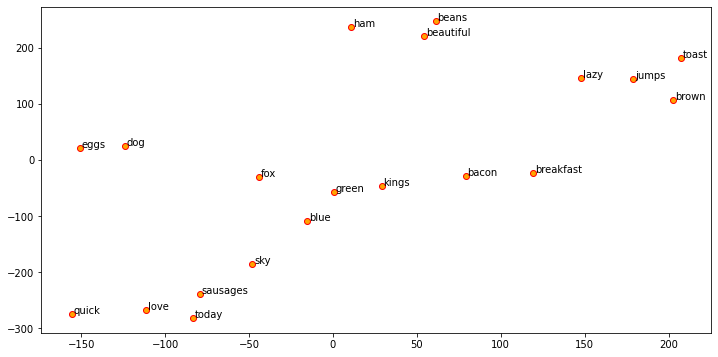

In [7]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

- Extract word embedding for specific words:

In [8]:
w2v_model.wv['sky']

array([ 0.04913035, -0.04127565, -0.02100882, -0.04237808, -0.03005596,
        0.00605162,  0.02097021, -0.03607806, -0.03568011, -0.03890556],
      dtype=float32)

### From Word Embeddings to Document Embeddings

In [9]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [10]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

/Users/Alvin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
0,0.028039,0.012040,-0.015245,-0.032109,-0.026944,-0.009046,0.031204,-0.030079,-0.019350,-0.024839
1,0.023543,0.000742,-0.020602,-0.011407,-0.019463,0.003290,0.024117,-0.027253,-0.023393,-0.011111
2,0.034437,0.007243,0.008340,0.024435,0.007650,-0.011598,0.007467,0.019464,-0.005437,0.006454
3,-0.007149,-0.002834,-0.004149,0.007236,0.006280,-0.009766,0.000145,-0.017501,0.005944,-0.012370
4,0.012254,-0.008715,-0.009513,0.023757,-0.000031,0.007848,0.009846,-0.015973,-0.009025,-0.006847
5,0.030962,0.014488,0.002185,0.011681,0.000169,-0.006813,0.016576,0.016151,-0.014029,-0.004731
6,0.017031,-0.001323,-0.022463,-0.018064,-0.017239,-0.000827,0.030662,-0.035184,-0.026944,-0.017503
7,0.035123,0.008750,0.011641,0.019841,0.009162,-0.005466,0.012287,0.023015,-0.009047,0.001844


### Clustering Documents based on Embeddings

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

similarity_doc_matrix = cosine_similarity(w2v_feature_array)
similarity_doc_df = pd.DataFrame(similarity_doc_matrix)
similarity_doc_df

,0,1,2,3,4,5,6,7
0,1.000000,0.915080,-0.094040,0.113092,0.236315,0.315747,0.925684,-0.025380
1,0.915080,1.000000,-0.038577,0.096463,0.535207,0.322584,0.975686,0.010120
2,-0.094040,-0.038577,1.000000,-0.295302,0.278592,0.869690,-0.171759,0.973033
3,0.113092,0.096463,-0.295302,1.000000,0.369362,-0.335530,0.224588,-0.381182
4,0.236315,0.535207,0.278592,0.369362,1.000000,0.300383,0.477479,0.251118
5,0.315747,0.322584,0.869690,-0.335530,0.300383,1.000000,0.208404,0.919848
6,0.925684,0.975686,-0.171759,0.224588,0.477479,0.208404,1.000000,-0.115047
7,-0.025380,0.010120,0.973033,-0.381182,0.251118,0.919848,-0.115047,1.000000


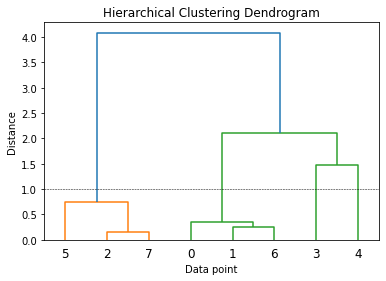

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_doc_matrix, 'ward')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,2
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,1


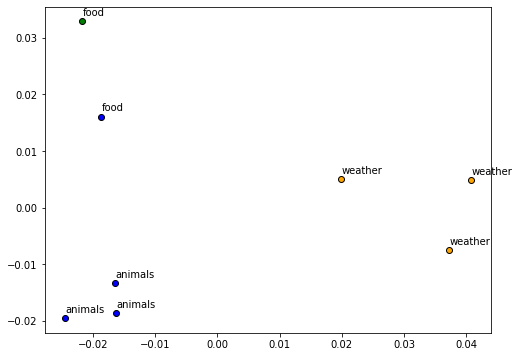

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

### Using Pre-trained Embeddings:  GloVe in `spacy`

In [15]:
import spacy

nlp = spacy.load('en_core_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 684830


### Visualize GloVe word embeddings

In [16]:
# get vocab of the corpus
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

# extract pre-trained embeddings of all words
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
breakfast,0.073378,0.227670,0.208420,-0.456790,-0.078219,0.601960,-0.024494,-0.467980,0.054627,2.28370,...,0.647710,0.373820,0.019931,-0.033672,-0.073184,0.296830,0.340420,-0.599390,-0.061114,0.232200
brown,-0.374120,-0.076264,0.109260,0.186620,0.029943,0.182700,-0.631980,0.133060,-0.128980,0.60343,...,-0.015404,0.392890,-0.034826,-0.720300,-0.365320,0.740510,0.108390,-0.365760,-0.288190,0.114630
kings,0.259230,-0.854690,0.360010,-0.642000,0.568530,-0.321420,0.173250,0.133030,-0.089720,1.52860,...,-0.470090,0.063743,-0.545210,-0.192310,-0.301020,1.068500,0.231160,-0.147330,0.662490,-0.577420
quick,-0.445630,0.191510,-0.249210,0.465900,0.161950,0.212780,-0.046480,0.021170,0.417660,1.68690,...,-0.329460,0.421860,-0.039543,0.150180,0.338220,0.049554,0.149420,-0.038789,-0.019069,0.348650
beautiful,0.171200,0.534390,-0.348540,-0.097234,0.101800,-0.170860,0.295650,-0.041816,-0.516550,2.11720,...,-0.285540,0.104670,0.126310,0.120040,0.254380,0.247400,0.207670,0.172580,0.063875,0.350990
love,0.139490,0.534530,-0.252470,-0.125650,0.048748,0.152440,0.199060,-0.065970,0.128830,2.05590,...,-0.124380,0.178440,-0.099469,0.008682,0.089213,-0.075513,-0.049069,-0.015228,0.088408,0.302170
blue,0.129450,0.036518,0.032298,-0.060034,0.399840,-0.103020,-0.507880,0.076630,-0.422920,0.81573,...,-0.501280,0.169010,0.548250,-0.319380,-0.072887,0.382950,0.237410,0.052289,0.182060,0.412640
sky,0.312550,-0.303080,0.019587,-0.354940,0.100180,-0.141530,-0.514270,0.886110,-0.530540,1.55660,...,-0.667050,0.279110,0.500970,-0.277580,-0.143720,0.342710,0.287580,0.537740,0.363490,0.496920
bacon,-0.430730,-0.016025,0.484620,0.101390,-0.299200,0.761820,-0.353130,-0.325290,0.156730,0.87321,...,0.304240,0.413440,-0.540730,-0.035930,-0.429450,-0.246590,0.161490,-1.065400,-0.244940,0.269540
ham,-0.773320,-0.282540,0.580760,0.841480,0.258540,0.585210,-0.021890,-0.463680,0.139070,0.65872,...,0.464470,0.481400,-0.829200,0.354910,0.224530,-0.493920,0.456930,-0.649100,-0.131930,0.372040


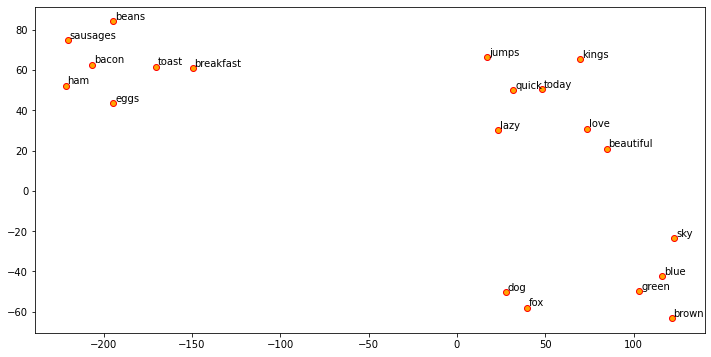

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Clustering Documents based on GloVe Embeddings

In [ ]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

import sklearn
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,1
7,The dog is lazy but the brown fox is quick!,animals,2


## Bible Corpus

In [18]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


### Training Embeddings Using word2vec Skip-gram


In [19]:
%%time
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50, sg = 1) # `sg=1` for skip-gram; `sg=0` for CBOW

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

CPU times: user 3min 31s, sys: 880 ms, total: 3min 32s
Wall time: 1min 25s


{'god': ['lord', 'jesurun', 'unto', 'loammi', 'malchus'],
 'jesus': ['christ', 'faith', 'grace', 'world', 'disciples'],
 'noah': ['overspread', 'kenan', 'asswaged', 'enosh', 'methuselah'],
 'egypt': ['land', 'pharaoh', 'egyptians', 'lubim', 'assaying'],
 'john': ['baptist', 'james', 'peter', 'devine', 'jeremias'],
 'gospel': ['preached', 'preach', 'christ', 'communicated', 'luke'],
 'moses': ['aaron', 'commanded', 'congregation', 'eleazar', 'spake'],
 'famine': ['pestilence', 'peril', 'overtaketh', 'belied', 'execration']}

### Visualizing word embeddings

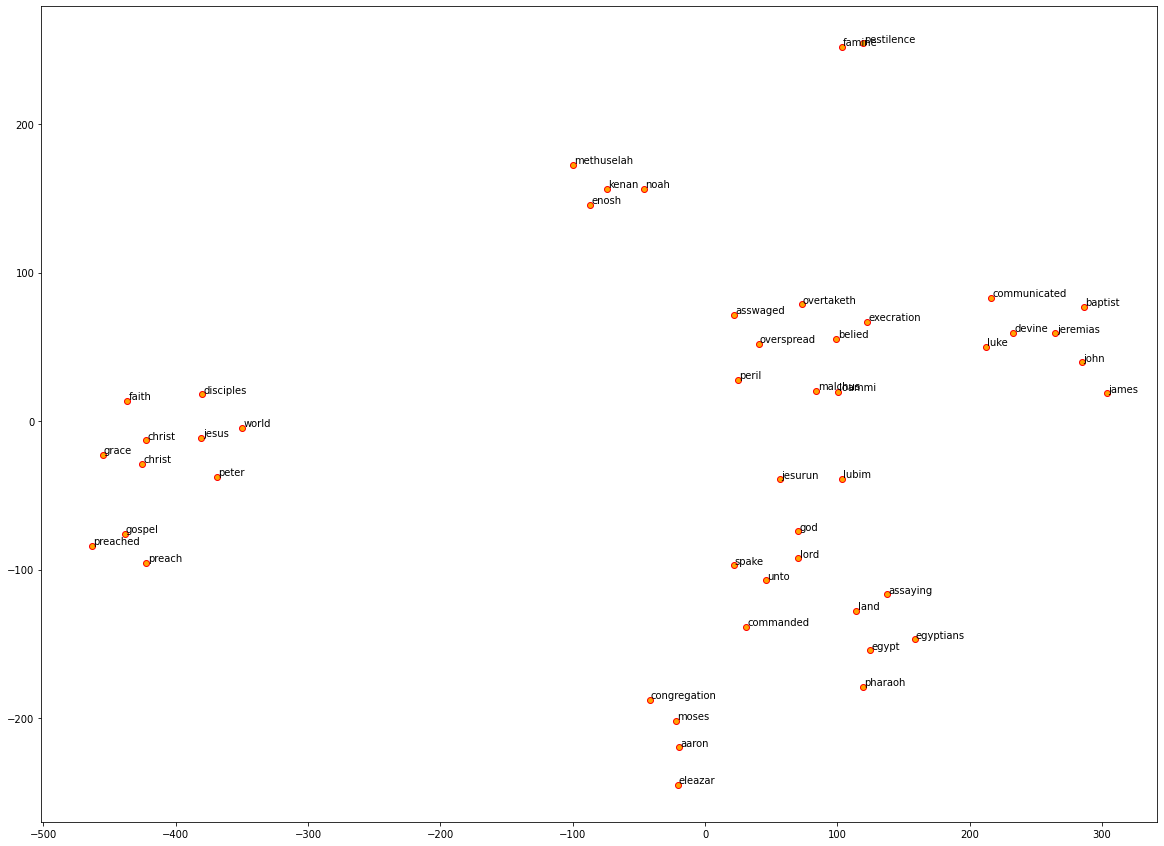

In [25]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(20, 15))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Training Embeddings Using fasttext model

In [ ]:
%%time
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)


CPU times: user 8min 31s, sys: 799 ms, total: 8min 32s
Wall time: 4min 21s


In [ ]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'egypt': ['land', 'pharaoh', 'egyptians', 'israel', 'pathros'],
 'famine': ['pestilence', 'sword', 'sojourn', 'dearth', 'blasted'],
 'god': ['lord', 'unto', 'therefore', 'jesus', 'christ'],
 'gospel': ['preached', 'christ', 'preach', 'preaching', 'gentiles'],
 'jesus': ['christ', 'disciples', 'god', 'faith', 'believe'],
 'john': ['baptist', 'peter', 'baptize', 'jesus', 'galilee'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'children'],
 'noah': ['shem', 'methuselah', 'flood', 'milcah', 'spared']}

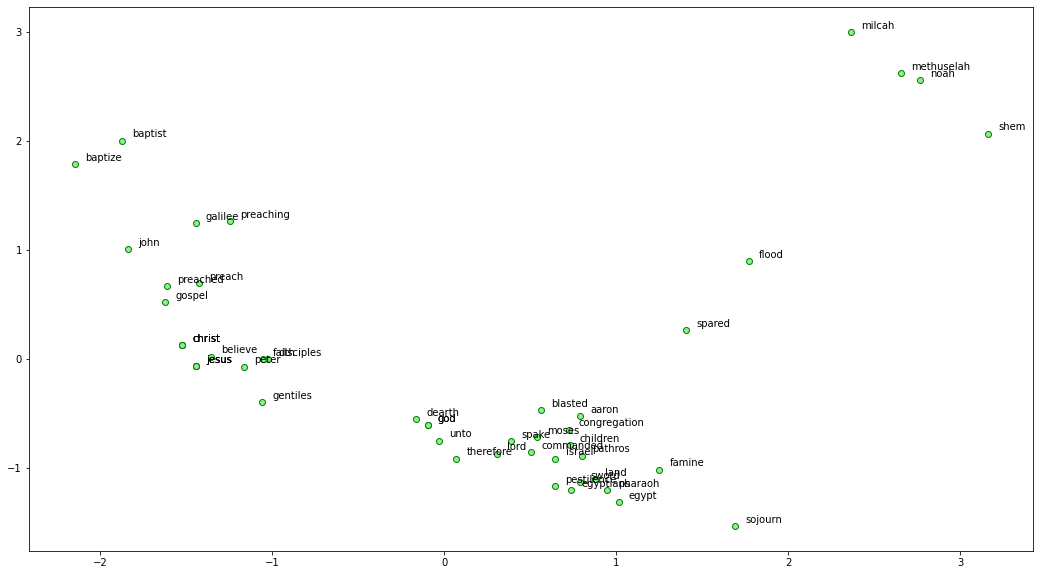

In [ ]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [ ]:
ft_model.wv['jesus']

array([-0.3953627 ,  0.04628759, -0.26783952,  0.34480003,  0.05829401,
        0.15185817, -0.6379116 , -0.05979184, -0.13532296,  0.09695553,
        0.22254673, -0.17305034, -0.2131626 , -0.1880864 ,  0.07641878,
        0.12035105,  0.0510335 ,  0.06099931, -0.08274286, -0.43099135,
       -0.04874687,  0.00895076, -0.10825669,  0.22005303,  0.42741376,
       -0.56019205, -0.01402027,  0.24010928,  0.0281704 ,  0.27202088,
       -0.04582407, -0.04499518, -0.13227846,  0.31134814,  0.07179902,
        0.38616648,  0.18817388,  0.03754657, -0.39480275,  0.27223426,
       -0.17002295,  0.03233609,  0.11192838,  0.16076459, -0.03300866,
       -0.26127887, -0.16765709,  0.35647735,  0.06123507, -0.18913624,
        0.13190822, -0.20054868,  0.08095483, -0.13850912,  0.22569895,
        0.5384312 ,  0.22163107,  0.4378083 , -0.03767192, -0.25173214,
       -0.13077395, -0.86384505,  0.07873806,  0.10031793,  0.22236028,
        0.33672985,  0.04272396,  0.4111791 ,  0.19088392,  0.20

In [ ]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

0.33838776
0.66813034


In [ ]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## References

- Sarkar (2020) Ch 4 Feature Engineering for Text Representation